<a href="https://colab.research.google.com/github/clv07/stroke-of-luck/blob/Data-import/MI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  PatientID                                Statement_codes Source
0   HR00001                                        22,1684  PTBXL
1   HR00002                      21,542,1665,531,1666,1693  PTBXL
2   HR00003                                        22,1684  PTBXL
3   HR00004  19,177,222,177,246,380,542,1665,533,1666,1693  PTBXL
4   HR00005                                        22,1684  PTBXL
Merged Data Sample:
  PatientID                                Statement_codes Source  \
0   HR00001                                        22,1684  PTBXL   
1   HR00002                      21,542,1665,531,1666,1693  PTBXL   
2   HR00003                                        22,1684  PTBXL   
3   HR00004  19,177,222,177,246,380,542,1665,533,1666,1693  PTBXL   
4   HR00005                                        22,1684  PTBXL   
5   HR00006                                        22,1684  PTBXL   
6   HR00007             22,548,1665,530,1683,533,1666,1693  PTBXL   
7   HR00008              22,542,

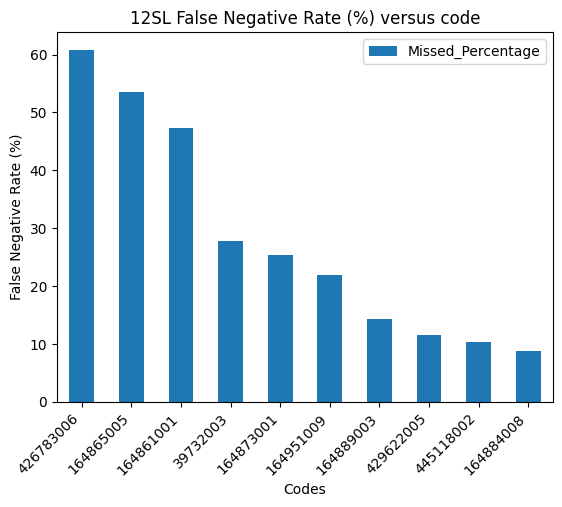

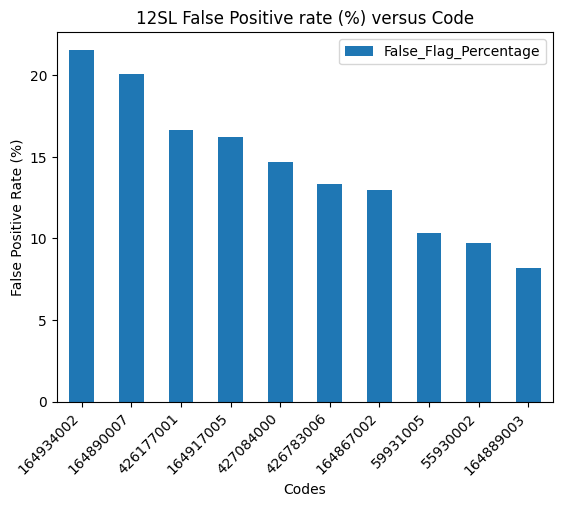

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

###############################################################################
# STEP 1: READ AND PROCESS EACH 12SL CSV
###############################################################################
def standardize_patient_id(patient_id):
    """
    Standardizes the PatientID:
    - If it ends with '_hr' (e.g., '00001_hr'), it is converted to 'HR00001'.
    - If it's already correctly formatted (e.g., 'A00001'), it remains unchanged.
    """
    if isinstance(patient_id, str) and re.match(r"^\d+_hr$", patient_id):
        numeric_part = patient_id.split("_")[0]  # Extract '00001'
        return f"HR{numeric_part}"  # Convert to 'HR00001'
    return patient_id  # Leave unchanged if already correct


def read_and_process_12sl(folder_path, dataset_name=None):
    """
    Reads and processes the 12SL data from a given folder, which contains:
    - meas.csv (has TestID and PatientID)
    - 12slv24_stt.csv (has TestID and statement codes)

    Parameters:
    - folder_path (str): The folder containing the two CSV files.
    - dataset_name (str, optional): The dataset name.

    Returns:
    - pd.DataFrame: Processed DataFrame with 'PatientID', 'Statement_codes', and 'Source'.
    """
    meas_path = os.path.join(folder_path, "meas.csv")
    stt_path = os.path.join(folder_path, "12slv24_stt.csv")

    if not os.path.exists(meas_path) or not os.path.exists(stt_path):
        print(f"Warning: One or both files missing in {folder_path}. Skipping.")
        return pd.DataFrame(columns=["PatientID", "Statement_codes", "Source"])  # Return empty if missing files

    # Read meas.csv (contains TestID and PatientID)
    df_meas = pd.read_csv(meas_path)

    # Read 12slv24_stt.csv (contains TestID and codes)
    df_stt = pd.read_csv(stt_path)

    # Ensure 'TestID' and 'PatientID' are correctly named
    first_col_meas = df_meas.columns[0]  # TestID
    second_col_meas = df_meas.columns[1]  # PatientID
    df_meas.rename(columns={first_col_meas: "TestID", second_col_meas: "PatientID"}, inplace=True)

    first_col_stt = df_stt.columns[0]  # TestID
    df_stt.rename(columns={first_col_stt: "TestID"}, inplace=True)

    # Merge on TestID, but retain only PatientID
    df_raw = pd.merge(df_meas[["TestID", "PatientID"]], df_stt, on="TestID", how="inner")

    # Standardize PatientID formatting
    df_raw["PatientID"] = df_raw["PatientID"].apply(standardize_patient_id)

    # Process Statement Codes
    if len(df_raw.columns) == 3:  # If only TestID, PatientID, and one column of statements
        df_raw["Statement_codes"] = (
            df_raw.iloc[:, 2]
            .astype(str)
            .str.strip("|")
            .str.replace("|", ",")
        )
    else:  # If multiple statement code columns exist
        code_cols = df_raw.columns[2:]
        df_raw["Statement_codes"] = df_raw[code_cols].apply(
            lambda row: ",".join(row.dropna().astype(str)), axis=1
        )

    # Keep only PatientID and Statement_codes
    df_processed = df_raw[["PatientID", "Statement_codes"]].copy()


    # Add Source column
    if dataset_name:
        df_processed["Source"] = dataset_name

    return df_processed

# Define dataset folder paths
ptbxl_folder = "./PTBXL"
shaoxing_folder = "./Shaoxing"
cpsc_folder = "./CPSC2018"

# Process each dataset
df_ptbxl = read_and_process_12sl(ptbxl_folder, dataset_name="PTBXL")
df_shaoxing = read_and_process_12sl(shaoxing_folder, dataset_name="Shaoxing")
df_cpsc = read_and_process_12sl(cpsc_folder, dataset_name="CPSC2018")

# Concatenate all 12SL data.
df_12sl_combined = pd.concat([df_ptbxl, df_shaoxing, df_cpsc], ignore_index=True)

print(df_12sl_combined.head())

###############################################################################
# STEP 2: READ AND PREPARE THE results.csv (PHYSICIAN CODES)
###############################################################################
results_csv = r"./results.csv"
df_results = pd.read_csv(results_csv)

# The results.csv sample has headers: patient_num and codes.
# Rename these to "TestID" and "Statements_Phys" so that we can merge.
df_results.rename(columns={"patient_num": "PatientID", "codes": "Statements_Phys"}, inplace=True)

# It may be necessary to strip any extra spaces from the codes:
df_results["Statements_Phys"] = df_results["Statements_Phys"].astype(str).str.strip()

###############################################################################
# STEP 3: MERGE THE 12SL DATA WITH THE PHYSICIAN DATA
###############################################################################
# Merge on the patient ID. Use inner join if you want only matching IDs.
df_merged = pd.merge(df_12sl_combined, df_results, on="PatientID", how="inner")

###############################################################################
# STEP 4: DEFINE MI CODE SETS AND CREATE BINARY INDICATORS
###############################################################################
# Example MI code sets (update these with the actual codes you consider for MI)
MI_codes_12SL = {
    700, 740, 760, 780, 801, 810, 820, 826, 827, 828, 829,
    920, 930, 940, 950, 960, 961, 962, 963, 964, 965, 966, 967, 968,
    # ... add others as needed
}

MI_codes_Phys = {
    57054005, 413444003, 426434006, 54329005, 425419005,
    425623009, 164865005, 164861001,
    # ... add others as needed
}
# Pairs matching codes from different systems to common condition, formatted
# "Conditon" : [num_one, num_two ...] , use to identify shared diagnoses
# between physicians and 12SL
MI_code_mapping = {
    "anterior infarct": [740, 810, 820, 54329005],
    "septal infarct": [700, 810],
    "lateral infarct": [760, 820, 425623009],
    "inferior infarct": [780, 801, 806, 425419005],
    "posterior infarct": [801, 802, 803],
    "infarct - ST elevation": [826, 827, 963, 964, 965, 966, 967, 968],
    "acute MI or injury": [4, 821, 822, 823, 826, 827, 828, 829, 920, 930, 940, 950, 960, 961, 962, 1361, 57054005, 413444003, 426434006, 164865005, 164861001]
}

def flag_mi(codes_str, mi_set):
    """
    Given a string of codes separated by commas (possibly with spaces),
    returns 1 if any code (converted to int) is in the mi_set, else 0.
    """
    if pd.isna(codes_str) or codes_str.strip() == "":
        return 0
    codes = [c.strip() for c in codes_str.split(",") if c.strip()]
    for code in codes:
        try:
            if int(code) in mi_set:
                return 1
        except ValueError:
            continue
    return 0

def GivenXInspection(df, codes_str, mi_column, mi_code_mapping):
    """
    Given a Merged DF with 1) Patient Labels, 2) 12SL Codes, 3) Physician Codes,
    4) MI_12SL, 5) MI_Phys, determine the probability of 12SL correctly identifying
    a symptom given a set of codes (i.e., Probability of 12SL detecting MI given ST Elevation).

    Args:
        df (pd.DataFrame): The merged dataframe containing MI flags.
        codes_str (str): A condition category representing the "given" signal (e.g., "anterior infarct").
        mi_column (str): The column name representing the 12SL calculated Condition flag (e.g., "MI_12SL").
        mi_code_mapping (dict): A dictionary mapping condition categories to a list of associated codes.

    Returns:
        float: Probability of correct identification.
    """
    # Get the relevant codes for the given condition
    condition_codes = set(mi_code_mapping.get(codes_str, []))

    # Convert Statements_Phys to sets for efficient lookup
    df["Statements_Phys_Set"] = df["Statements_Phys"].apply(lambda x: set(map(int, x.split(','))) if pd.notna(x) else set())

    # Identify cases where at least one given condition code is present in the physician's statements
    signal_present = df[df["Statements_Phys_Set"].apply(lambda codes: not condition_codes.isdisjoint(codes))]

    # Further filter cases where the physician also flagged MI
    mi_positive_patients = signal_present.loc[signal_present["MI_Phys"] == 1, "PatientID"]

    if mi_positive_patients.empty:
        return 0  # Avoid division by zero if no cases exist

    # Filter 12SL-flagged cases only for identified patients
    correct_identifications = df.loc[df["PatientID"].isin(mi_positive_patients), mi_column].sum()

    # Calculate probability
    probability = correct_identifications / len(mi_positive_patients)

    return probability

def LabelMapping(df_merged, mi_code_mapping):
    """
    Given a Merged DF with 1) Patient Labels, 2) 12SL Codes, 3) Physician Codes,
    4) MI_12SL, 5) MI_Phys, break down the identified signs by 12SL & Physicians
    to categorize label percentages in missed and false flag cases.

    Args:
        df_merged (pd.DataFrame): The merged dataframe containing MI-related flags.
        mi_code_mapping (dict): A dictionary mapping condition categories to lists of associated codes.

    Returns:
        tuple: Two DataFrames -
            - df_code_percentages: Breakdown of missed/false flag percentages per code.
            - df_signal_percentages: Breakdown of missed/false flag percentages per condition category.
    """

    # Gather cases flagged by physicians but missed by 12SL
    df_missed_by_12sl = df_merged[(df_merged["MI_Phys"] == 1) & (df_merged["MI_12SL"] == 0)]

    # Gather cases flagged by 12SL but not confirmed by physicians
    df_false_id = df_merged[(df_merged["MI_12SL"] == 1) & (df_merged["MI_Phys"] == 0)]

    # Function to count occurrences of each code
    def count_codes(df):
        code_counts = {}
        for codes in df["Statements_Phys"].dropna():
            for code in map(int, codes.split(',')):  # Convert to int to ensure consistency
                code_counts[code] = code_counts.get(code, 0) + 1
        return code_counts

    # Count occurrences in missed and false flag cases
    missed_code_counts = count_codes(df_missed_by_12sl)
    false_code_counts = count_codes(df_false_id)

    # Convert counts to DataFrames
    df_code_percentages = pd.DataFrame([
        {"Code": code,
         "Missed_Percentage": missed_code_counts.get(code, 0) / len(df_missed_by_12sl) * 100 if len(df_missed_by_12sl) > 0 else 0,
         "False_Flag_Percentage": false_code_counts.get(code, 0) / len(df_false_id) * 100 if len(df_false_id) > 0 else 0}
        for code in set(missed_code_counts) | set(false_code_counts)  # Include all unique codes
    ])

    # Aggregate by signal type (condition category)
    signal_counts = {}
    for condition, codes in mi_code_mapping.items():
        signal_counts[condition] = {
            "Missed_Percentage": sum(missed_code_counts.get(code, 0) for code in codes) / len(df_missed_by_12sl) * 100 if len(df_missed_by_12sl) > 0 else 0,
            "False_Flag_Percentage": sum(false_code_counts.get(code, 0) for code in codes) / len(df_false_id) * 100 if len(df_false_id) > 0 else 0
        }

    df_signal_percentages = pd.DataFrame.from_dict(signal_counts, orient="index").reset_index().rename(columns={"index": "Condition"})

    return df_code_percentages, df_signal_percentages
# Create MI flags for 12SL and Physician.
df_merged["MI_12SL"] = df_merged["Statement_codes"].apply(lambda x: flag_mi(x, MI_codes_12SL))
df_merged["MI_Phys"]  = df_merged["Statements_Phys"].apply(lambda x: flag_mi(x, MI_codes_Phys))

###############################################################################
# STEP 5: INSPECTION / ANALYSIS
###############################################################################
print("Merged Data Sample:")
print(df_merged.head(10))
print(df_merged.columns)
print(f"Total merged records: {len(df_merged)}")
print(f"Total MI flagged by 12SL: {df_merged['MI_12SL'].sum()}")
print(f"Total MI flagged by Physician: {df_merged['MI_Phys'].sum()}")

# For example, cases flagged by Physician but not by 12SL (False Negative):
df_missed_by_12sl = df_merged[(df_merged["MI_Phys"] == 1) & (df_merged["MI_12SL"] == 0)]
print(f"Records where Physician flagged MI but 12SL did not: {len(df_missed_by_12sl)}")

# Case 2) Cases Flagged by 12SL but not by Physician (False Positive)
df_false_id = df_merged[(df_merged["MI_12SL"] == 1) & (df_merged["MI_Phys"] == 0)]
print(f"Records where 12SL flagged MI but Physician did not: {len(df_false_id)}")

# Case 3)
# a) Given STEMI, What is the chance that 12SL calculated it correctly
prob_given_STElevation = GivenXInspection(df_merged,"infarct - ST elevation","MI_12SL", MI_code_mapping)
print(f"Probability of 12SL identifying MI given ST Elevation: {prob_given_STElevation * 100} %")

# b) Given MI, What is the chance that 12SL calculated it correctly
prob_given_lateral = GivenXInspection(df_merged,"acute MI or injury","MI_12SL", MI_code_mapping)
print(f"Probability of 12SL identifying MI given MI or Injury: {prob_given_lateral * 100}")

# Conditional Breakdown of Missed regions
breakdown = LabelMapping(df_merged, MI_code_mapping)
df_by_code = breakdown[0]
df_by_signal = breakdown[1]
print(df_by_code.sort_values(by='False_Flag_Percentage', ascending=False))
print(df_by_code.sort_values(by='Missed_Percentage', ascending=False))
print(df_by_signal.sort_values(by='Missed_Percentage', ascending=False))

###############################################################################
# STEP 6: GRAPHS
###############################################################################

# GRAPH 1) MISSED PERCENTAGE (DESCENDING) VS CODE
ax1 = df_by_code.sort_values(by="Missed_Percentage",ascending=False).head(10).plot.bar(x='Code', y='Missed_Percentage')
ax1.set_xlabel("Codes")
ax1.set_ylabel("False Negative Rate (%)")
plt.title('12SL False Negative Rate (%) versus code')
plt.xticks(rotation=45, ha='right')
plt.show()
# GRAPH 2) FALSE FLAG (DESCENDING) VS CODE
ax1 = df_by_code.sort_values(by="False_Flag_Percentage",ascending=False).head(10).plot.bar(x='Code', y='False_Flag_Percentage')
ax1.set_xlabel("Codes")
ax1.set_ylabel("False Positive Rate (%)")
plt.title('12SL False Positive rate (%) versus Code')
plt.xticks(rotation=45, ha='right')
plt.show()

###############################################################################
# STEP 7: OUTPUT
###############################################################################
# Update DF to generate two CSV's, Positive 12SL MI Flags and Negative Flags, and 12SL measurements

# Trim and Rename
df_merged = df_merged.drop('Statements_Phys_Set', axis=1)
df_merged.rename(columns={'Statement_codes' : '12SL_Codes', 'Statements_Phys' : 'Phys_Codes'}, inplace= True)

# Refine Measurement Files

meas_path = "/content/PTBXL/meas.csv"
df_meas_PT = pd.read_csv(meas_path)
df_meas_PT["PatientID"] = df_meas_PT["PatientID"].apply(standardize_patient_id)

meas_path = "/content/Shaoxing/meas.csv"
df_meas_SH = pd.read_csv(meas_path)
df_meas_SH["PatientID"] = df_meas_SH["PatientID"].apply(standardize_patient_id)

meas_path = "/content/CPSC2018/meas.csv"
df_meas_CS = pd.read_csv(meas_path)
df_meas_CS["PatientID"] = df_meas_CS["PatientID"].apply(standardize_patient_id)

df_meas = pd.concat([df_meas_CS,df_meas_PT,df_meas_SH],axis=0)
# Join on PatientIDs
df_merged = pd.merge(df_merged,df_meas,how="left", on=["PatientID"])

#df_merged = pd.merge(df_merged,df_meas_SH,how="left", on=["PatientID"])
#df_merged = pd.merge(df_merged,df_meas_CS,how="left", on=["PatientID"])

# Seperate Into Two CSV's

# a) Positive MI
df_positive = df_merged[df_merged["MI_12SL"] == 1]
# b) Negative MI
df_negative = df_merged[df_merged["MI_12SL"] == 0]

df_merged.to_csv("dataset.csv", index=False)
df_positive.to_csv("positive.csv", index=False)
df_negative.to_csv("negative.csv", index=False)


In [ ]:
###############################################################################
# STEP 8: TEST
###############################################################################
# Test cases to verify datasets are being properly joined

def read_file(folder, file):
    return pd.read_csv(os.path.join(folder, file))

meas_name = "meas.csv"
stt_name = "12slv24_stt.csv"
sources = ["Shaoxing", "PTBXL", "CPSC2018"]

datasets = {source: (read_file(source, meas_name), read_file(source, stt_name)) for source in sources}

output_df = pd.read_csv("merged_output.csv")
physician_diag = pd.read_csv("results.csv")

original_id = pd.concat([df["PatientID"] for df, _ in datasets.values()])
output_id = output_df["PatientID"]

# No missing entries
assert sorted(original_id) == sorted(output_id), "Missing entries"

# Duplicate Patient ID
# assert len(output_id) == len(output_id.unique()), "Duplicate Patient ID" # failing
visit, dup = set(), []
for id in output_id:
    dup.append(id) if id in visit else visit.add(id)

print(f"Duplicate Patient ID: {dup}")
for id in dup:
    print(output_df[output_df["PatientID"] == id])

# Correct format of Patient ID
id_format = r"^[A-Z]+\d+$"
assert output_df["PatientID"].str.match(id_format).all(), "Incorrect format Patient ID"

def convert_format(s):
    return re.sub(r"^(\d+)_([a-z]+)$", lambda m: m.group(2).upper() + m.group(1), s)

for source, (meas, stt) in datasets.items():
    output = output_df[output_df["Source"] == source]
    original_id = meas["PatientID"].apply(convert_format) if source == "PTBXL" else meas["PatientID"]
    assert sorted(output_id.tolist()) == sorted(original_id.tolist()), f"Mismatch found for {source}"

    # Physician code mapping
    for id in output_id:
        original_phys = physician_diag[physician_diag["patient_num"] == id]["codes"]
        output_phys = output_df[output_df["PatientID"] == id]["Statements_Phys"]
        assert not output_phys.empty, f"Physicians statement code missing for Patient ID {id}"
        assert sorted(original_phys) == sorted(output_phys), f"Incorrect physician statement code mapping for Patient ID {id}"

    # 12SL code mapping
    merged_df = meas.merge(stt, on="TestID", how="inner")[['PatientID', 'Statements']]
    for id in output_id:
        original_12sl = merged_df[merged_df["PatientID"] == id]["Statements"]
        output_12sl = output_df[output_df["PatientID"] == id]["Statements_12SL"]
        assert not output_12sl.empty, f"12SL statement code missing for Patient ID {id}"
        assert sorted(original_12sl) == sorted(output_12sl), f"Incorrect 12SL statement code mapping for Patient ID {id}"

    # Physician diagnosis
    for id in output_id:
        output_phys = output_df[output_df["PatientID"] == id]["Statements_Phys"]
        output_phys = [code for code in output_phys if code in MI_codes_Phys]
        output_phys_mi = 1 if output_phys else 0
        assert "MI_Phys" in output_df.columns, f"Missing MI_Phys column for Patient ID {id}"
        assert output_df.loc[output_df["PatientID"] == id, "MI_Phys"].values[0] == output_phys_mi, f"Incorrect Physician MI flag for Patient ID {id}"

    # 12SL diagnosis
    for id in output_id:
        output_12sl = output_df[output_df["PatientID"] == id]["Statement_codes"]
        output_12sl = [code for code in output_12sl if code in MI_codes_12SL]
        output_12sl_mi = 1 if output_12sl else 0
        assert "MI_12SL" in output_df.columns, f"Missing MI_12SL column for Patient ID {id}"
        assert output_df.loc[output_df["PatientID"] == id, "MI_12SL"].values[0] == output_12sl_mi, f"Incorrect 12SL MI flag for Patient ID {id}"

Duplicate Patient ID: ['A0001', 'Q0001']
     PatientID           Statement_codes    Source Statements_Phys  MI_12SL  \
2751     A0001  161,171,440,700,831,1699  Shaoxing        59118001        1   
2753     A0001                   21,1687  Shaoxing        59118001        0   

      MI_Phys Statements_Phys_Set  
2751        0          {59118001}  
2753        0          {59118001}  
     PatientID Statement_codes    Source       Statements_Phys  MI_12SL  \
2752     Q0001    21,1140,1699  Shaoxing  164867002, 427084000        0   
9630     Q0001         21,1687  Shaoxing  164867002, 427084000        0   

      MI_Phys     Statements_Phys_Set  
2752        0  {427084000, 164867002}  
9630        0  {427084000, 164867002}  
